In [1]:
# Import libraries
import utils.mnist_reader as mnist_reader
import time
import numpy as np
from dask import delayed, compute
from numba import njit
import matplotlib.pyplot as plt

In [2]:
# Import Fashion-MNIST dataset
X, y = mnist_reader.load_mnist('data/fashion', kind='train')

# Convert data type to be float 64 bit
X = X.astype(np.float64)

# Change the label from multi-labels to binary
# The original label is [0,1,...,9]
# Convert to -1 and 1, where -1 is even number and odd number
bi_y = [1 if e%2 else -1 for e in y]
y = np.array(bi_y, dtype=np.int32)

# Numpy

In [3]:
# Passive Aggressive Algorithm for binary classification
def fit(X, y, max_iter):
    '''
    Train classifier
    '''
    n_features = len(X[0])
    weight = np.zeros(n_features, dtype=np.float64)
    for epoch in range(max_iter):
        # For each data point in the training set
        for i, x in enumerate(X):
            # Predict using the current weights
            a = np.dot(weight, x)
            pred = int(np.sign(a))
            # If the prediction is wrong
            if pred != y[i]:
                # calculate L2 norm square
                l2sq = np.linalg.norm(x, ord=2)**2
                # calculate learning rate
                learning_rate = (1 - (y[i] * a)) / l2sq
                # Update the weights
                weight += (learning_rate * y[i]) * x
    
    return weight

def predict(X, weight):
    '''
    Predict label
    '''
    # Initialize prediction list
    predictions = np.zeros(len(X), dtype=np.int32)
    
    # For each data point in the testing set
    for i, x in enumerate(X):
        # Predict a label
        pred = np.sign(np.dot(weight, x))
        # Add to the prediction list
        predictions[i] = int(pred)
    # Return the prediction list
    return predictions

def mistake(pred, label):
    '''
    Find number of prediction mistakes
    '''
    n_mistake = np.sum(pred != label)
    # Return number of mistake
    return n_mistake

def plot(n_mistakes):
    '''
    Plot online learning curve
    '''
#     n = len(n_mistakes)
#     plt.plot(np.arange(1, n+1), n_mistakes)
#     plt.title("Online Learning Curve")
#     plt.xlabel("Iteration")
#     plt.ylabel("Number of mistake")
#     plt.xticks(np.arange(1, n+1))
#     plt.show()
    return sum(n_mistakes)

def online_learning_curve(n_iter):
    '''
    Compute number of mistake and plot online learning curve from 1 to n_iter iterations 
    '''
    n_mistakes = np.zeros(n_iter, dtype=np.int64)
    for i in range(1, n_iter+1):
        w = fit(X, y, i)
        pred = predict(X, w)
        n_mis = mistake(pred, y)
        n_mistakes[i-1] = n_mis
    
    plot(n_mistakes)

In [4]:
# Experament
n = 15
repeat = 5

ex_time = np.zeros(n, dtype=np.float64)

# Repeat experiment "repeat" times
for k in range(repeat):
    # Plot online learning curve n curves
    for i in range(1, n+1):
        start = time.time()
        online_learning_curve(i)
        end = time.time()
        ex_time[i-1] += end - start
        
ex_time = ex_time / repeat

In [5]:
print("Numpy excution time:", ex_time)
print("Numpy total time:", sum(ex_time))

Numpy excution time: [ 0.58918352  1.52984042  2.86202421  4.59866476  6.70462365  9.18097539
 12.1941927  15.45066485 19.65325332 23.0835598  27.54208174 31.9528903
 36.54343686 42.96819735 48.66805935]
Numpy total time: 283.5216482162475


# Numpy + Dask

In [10]:
# Passive Aggressive Algorithm for binary classification
@delayed
def dask_fit(X, y, max_iter):
    '''
    Train classifier
    '''
    n_features = len(X[0])
    weight = np.zeros(n_features, dtype=np.float64)
    for epoch in range(max_iter):
        # For each data point in the training set
        for i, x in enumerate(X):
            # Predict using the current weights
            a = np.dot(weight, x)
            pred = int(np.sign(a))
            # If the prediction is wrong
            if pred != y[i]:
                # calculate L2 norm square
                l2sq = np.linalg.norm(x, ord=2)**2
                # calculate learning rate
                learning_rate = (1 - (y[i] * a)) / l2sq
                # Update the weights
                weight += (learning_rate * y[i]) * x
    
    return weight

@delayed
def dask_predict(X, weight):
    '''
    Predict label
    '''
    # Initialize prediction list
    predictions = np.zeros(len(X), dtype=np.int32)
    
    # For each data point in the testing set
    for i, x in enumerate(X):
        # Predict a label
        pred = np.sign(np.dot(weight, x))
        # Add to the prediction list
        predictions[i] = int(pred)
    # Return the prediction list
    return predictions

@delayed
def dask_mistake(pred, label):
    '''
    Find number of prediction mistakes
    '''
    n_mistake = np.sum(pred != label)
    # Return number of mistake
    return n_mistake

@delayed
def dask_plot(n_mistakes):
    '''
    Plot online learning curve
    '''
#     n = len(n_mistakes)
#     plt.plot(np.arange(1, n+1), n_mistakes)
#     plt.title("Online Learning Curve")
#     plt.xlabel("Iteration")
#     plt.ylabel("Number of mistake")
#     plt.xticks(np.arange(1, n+1))
#     plt.show()
    return sum(n_mistakes)

def dask_online_learning_curve(n_iter):
    '''
    Compute number of mistake and plot an online learning curve, x-axis is from 1 to n_iter iterations 
    '''
#     n_mistakes = np.zeros(n_iter, dtype=np.int64)
    n_mistakes = []
    
    w = dask_fit(X, y, n_iter)
    pred = dask_predict(X, w)
    n_mis = dask_mistake(pred, y)
#     n_mistakes[i-1] = n_mis
    n_mistakes.append(n_mis)

    total = dask_plot(n_mistakes)
    total.compute()

In [11]:
# Experiment
dask_ex_time = np.zeros(n, dtype=np.float64)

# Repeat experiment "repeat" times
for k in range(repeat):
    # Plot online learning curve n curves
    for i in range(1, n+1):
        start = time.time()
        
        dask_online_learning_curve(i)

        end = time.time()
        dask_ex_time[i-1] += end - start
        
dask_ex_time = dask_ex_time / repeat

In [27]:
print("Numpy+Dask excution time:", dask_ex_time)
print("Numpy+Dask total time:", sum(dask_ex_time))

Numpy+Dask excution time: [0.57796416 0.92500849 1.28725739 1.62485852 1.98173232 2.34482808
 2.72045202 3.28210177 3.4205174  3.78754864 4.1198236  4.51883559
 4.81267529 5.22173362 5.67885871]
Numpy+Dask total time: 46.3041955947876


# Numpy + Numba

In [15]:
# Passive Aggressive Algorithm for binary classification
@njit(nogil=True)
def nb_fit(X, y, max_iter):
    '''
    Train classifier
    '''
    n_features = len(X[0])
    weight = np.zeros(n_features, dtype=np.float64)
    n = len(X)
    for epoch in range(max_iter):
        # For each data point in the training set
        for i in range(n):
            # Predict using the current weights
            a = np.dot(weight, X[i])
            pred = int(np.sign(a))
            # If the prediction is wrong
            if pred != y[i]:
                # calculate L2 norm square
                l2sq = np.linalg.norm(X[i], ord=2)**2
                # calculate learning rate
                learning_rate = (1 - (y[i] * a)) / l2sq
                # Update the weights
                weight += (learning_rate * y[i]) * X[i]
    
    return weight

@njit(nogil=True)
def nb_predict(X, weight):
    '''
    Predict label
    '''
    # Initialize prediction list
    predictions = np.zeros(len(X), dtype=np.int32)
    n = len(X)
    # For each data point in the testing set
    for i in range(n):
        # Predict a label
        pred = np.sign(np.dot(weight, X[i]))
        # Add to the prediction list
        predictions[i] = int(pred)
    # Return the prediction list
    return predictions

@njit(nogil=True)
def nb_mistake(pred, label):
    '''
    Find number of prediction mistakes
    '''
    n_mistake = np.sum(pred != label)
    # Return number of mistake
    return n_mistake

@njit(nogil=True)
def nb_plot(n_mistakes):
    '''
    Plot online learning curve
    '''
#     n = len(n_mistakes)
#     plt.plot(np.arange(1, n+1), n_mistakes)
#     plt.title("Online Learning Curve")
#     plt.xlabel("Iteration")
#     plt.ylabel("Number of mistake")
#     plt.xticks(np.arange(1, n+1))
#     plt.show()
    return np.sum(n_mistakes)

@njit(nogil=True)
def nb_online_learning_curve(n_iter):
    '''
    Compute number of mistake and plot online learning curve from 1 to n_iter iterations 
    '''
    n_mistakes = np.zeros(n_iter, dtype=np.int64)
    for i in range(1, n_iter+1):
        w = nb_fit(X, y, i)
        pred = nb_predict(X, w)
        n_mis = nb_mistake(pred, y)
        n_mistakes[i-1] = n_mis
    
    nb_plot(n_mistakes)

In [16]:
# Experiment
nb_ex_time = np.zeros(n, dtype=np.float64)

# Repeat experiment "repeat" times
for k in range(repeat):
    # Plot online learning curve n curves
    for i in range(1, n+1):
        start = time.time()
    
        nb_online_learning_curve(i)

        end = time.time()
        nb_ex_time[i-1] += end - start
        
nb_ex_time = nb_ex_time / repeat

In [28]:
print("Numpy+Numba excution time:", nb_ex_time)
print("Numpy+Numba total time:", sum(nb_ex_time))

Numpy+Numba excution time: [0.45491624 0.12660022 0.24216762 0.36704721 0.52403278 0.70050359
 0.94140897 1.13198943 1.39063129 1.7078536  2.07539172 2.46741586
 2.8068296  3.23344908 3.62868023]
Numpy+Numba total time: 21.79891743659973


# Numpy + Dask + Numba

In [20]:
def dnb_online_learning_curve(n_iter):
    '''
    Compute number of mistake and plot an online learning curve, x-axis is from 1 to n_iter iterations 
    '''
    n_mistakes = np.zeros(n_iter, dtype=np.int64)
    
    w = nb_fit(X, y, n_iter)
    pred = nb_predict(X, w)
    n_mis = nb_mistake(pred, y)
    n_mistakes[i-1] = n_mis

    total = dask_plot(n_mistakes)
    total.compute()

In [21]:
# Experiment
dnb_ex_time = np.zeros(n, dtype=np.float64)

# Repeat experiment "repeat" times
for k in range(repeat):
    # Plot online learning curve n curves
    for i in range(1, n+1):
        start = time.time()
    
        dnb_online_learning_curve(i)

        end = time.time()
        dnb_ex_time[i-1] += end - start
        
dnb_ex_time = dnb_ex_time / repeat

In [22]:
print("Numpy+Dask+Numba excution time:", dnb_ex_time)
print("Numpy+Dask+Numba total time:", sum(dnb_ex_time))

Dask + Numba excution time: [0.20279641 0.07960687 0.10745234 0.1333478  0.16448865 0.19561043
 0.20821261 0.24484959 0.27476373 0.33256712 0.33625221 0.35697484
 0.37751799 0.44102802 0.45877018]
Dask + Numba total time: 3.9142387866973873


# Plot graph

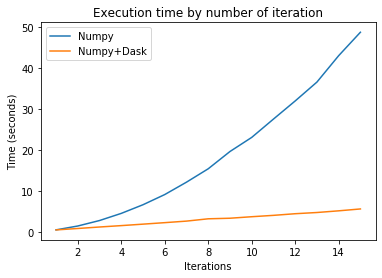

In [23]:
# Numpy vs Numpy+Dask

lb1 = "Numpy"
lb2 = "Numpy+Dask"
plt.plot(np.arange(1, n+1), ex_time, label=lb1)
plt.plot(np.arange(1, n+1), dask_ex_time, label=lb2)
plt.title("Execution time by number of iteration")
plt.xlabel("Iterations")
plt.ylabel("Time (seconds)")
plt.legend()
plt.show()

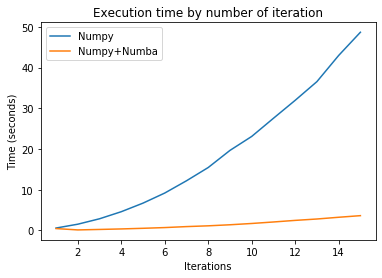

In [24]:
# Numpy vs Numpy+Numba

lb1 = "Numpy"
lb2 = "Numpy+Numba"
plt.plot(np.arange(1, n+1), ex_time, label=lb1)
plt.plot(np.arange(1, n+1), nb_ex_time, label=lb2)
plt.title("Execution time by number of iteration")
plt.xlabel("Iterations")
plt.ylabel("Time (seconds)")
plt.legend()
plt.show()

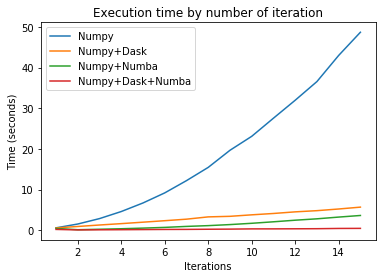

In [26]:
# Numpy vs Numpy+Dask vs Numpy+Numba vs Numpy+Dask+Numba

lb1 = "Numpy"
lb2 = "Numpy+Dask"
lb3 = "Numpy+Numba"
lb4 = "Numpy+Dask+Numba"
plt.plot(np.arange(1, n+1), ex_time, label=lb1)
plt.plot(np.arange(1, n+1), dask_ex_time, label=lb2)
plt.plot(np.arange(1, n+1), nb_ex_time, label=lb3)
plt.plot(np.arange(1, n+1), dnb_ex_time, label=lb4)
plt.title("Execution time by number of iteration")
plt.xlabel("Iterations")
plt.ylabel("Time (seconds)")
plt.legend()
plt.show()